
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [10]:
%matplotlib inline

In [11]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [12]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [13]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('./', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [3,5,7,8,9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [3, 5, 7, 8, 9]
    name: ['Hokkien Prawn Mee', 'Laksa', 'Oyster Omelette', 'Roast Meat Rice', 'Roti Prata']


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



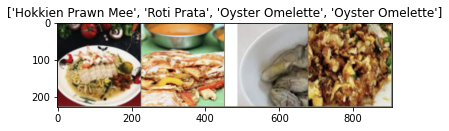

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=24):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_list = []
    acc_list = []
    
    loss_list_val = []
    acc_list_val = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        t1 = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                ## APPEND LOSS AND ACCURACY
                loss_list.append(epoch_loss)
                acc_list.append(epoch_acc)
            else:
                ## APPEND LOSS AND ACCURACY
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        t2=time.time()
        print('Time:'+str(t2-t1))
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,loss_list,acc_list,loss_list_val,acc_list_val

## 3.2 Defining Function to Vsualize Model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [43]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

# (code)

model = models.efficientnet_b1(pretrained=True)

# 2. Modify the pretrain model for your task.


for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 5)

# # (code)

# # 3. Choose your loss function, optimizer, etc.

criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as
# # opposed to before.
optimizer_conv = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
# optimizer_conv = optim.Adam(model.classifier.parameters())

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
# (code)

### 4.2 Printing and visualizing the modified model

In [44]:
# TODO
print(model)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [45]:
# TODO
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [46]:
# TODO 
model, loss_list, acc_list,loss_list_val,acc_list_val = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6091 Acc: 0.2200
val Loss: 1.5388 Acc: 0.2800
Time:29.331151008605957

Epoch 1/9
----------
train Loss: 1.5622 Acc: 0.2980
val Loss: 1.4845 Acc: 0.4733
Time:31.35258722305298

Epoch 2/9
----------
train Loss: 1.5045 Acc: 0.3900
val Loss: 1.4290 Acc: 0.5800
Time:31.710177421569824

Epoch 3/9
----------
train Loss: 1.4441 Acc: 0.4680
val Loss: 1.3749 Acc: 0.6467
Time:31.848085641860962

Epoch 4/9
----------
train Loss: 1.3985 Acc: 0.5640
val Loss: 1.3286 Acc: 0.7067
Time:31.058417081832886

Epoch 5/9
----------
train Loss: 1.3230 Acc: 0.6140
val Loss: 1.2852 Acc: 0.6933
Time:30.749252796173096

Epoch 6/9
----------
train Loss: 1.3007 Acc: 0.6180
val Loss: 1.2455 Acc: 0.7400
Time:31.120429515838623

Epoch 7/9
----------
train Loss: 1.2515 Acc: 0.6600
val Loss: 1.2377 Acc: 0.7533
Time:31.764952182769775

Epoch 8/9
----------
train Loss: 1.2788 Acc: 0.6220
val Loss: 1.2361 Acc: 0.7400
Time:30.777212142944336

Epoch 9/9
----------
train Loss: 1.2683 Acc: 0.

## 5. Loading test data

Define the dataset and dataloader for testing.

In [47]:
test_dir = os.path.join('./', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

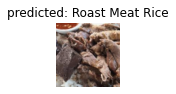

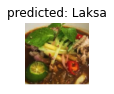

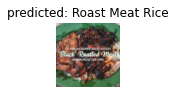

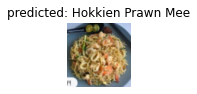

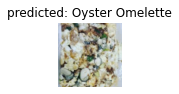

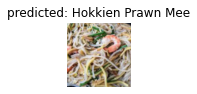

In [48]:
# TODO

# num_images = 4

# (code)

# with torch.no_grad():
    # Predict on the test set

    # (code)

    # Print the output images and labels
    
    # (code)

visualize_model(model)

plt.ioff()
plt.show()


## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [49]:
model.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

y_true = []
y_pred = []

wrong_detections = []
correct_detections = []

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        
        # Confusion Matrix
        
        y_true.extend(preds.numpy())
        y_pred.extend(labels.data.numpy())
        
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.6897


# Graphing Metrics

### Plotting Loss vs Iteration - Train

In [53]:
iterations = []

for i,loss in enumerate(loss_list):
    iterations.append(i)

In [54]:
iterations

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

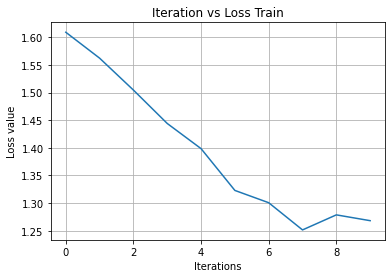

In [55]:
fig, ax = plt.subplots()
ax.plot(iterations, loss_list)

ax.set(xlabel='Iterations', ylabel='Loss value',
       title='Iteration vs Loss Train')
ax.grid()

plt.show()

### Plotting Loss vs Iteration - Val

In [56]:
iterations = []

for i,loss in enumerate(loss_list_val):
    iterations.append(i)

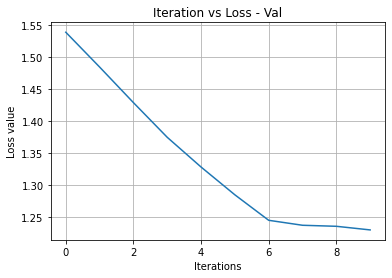

In [57]:
fig, ax = plt.subplots()
ax.plot(iterations, loss_list_val)

ax.set(xlabel='Iterations', ylabel='Loss value',
       title='Iteration vs Loss - Val')
ax.grid()

plt.show()

### Plotting Accuracy vs Iteration - Train

In [58]:
iterations = []

for i,loss in enumerate(acc_list):
    iterations.append(i)

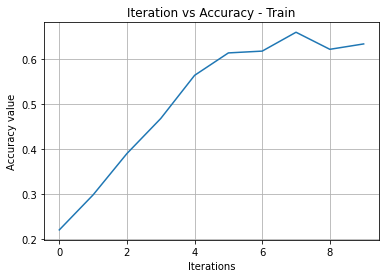

In [59]:
fig, ax = plt.subplots()
ax.plot(iterations, acc_list)

ax.set(xlabel='Iterations', ylabel='Accuracy value',
       title='Iteration vs Accuracy - Train')
ax.grid()

plt.show()

### Plotting Accuracy vs Iteration - Val

In [60]:
iterations = []

for i,loss in enumerate(acc_list_val):
    iterations.append(i)

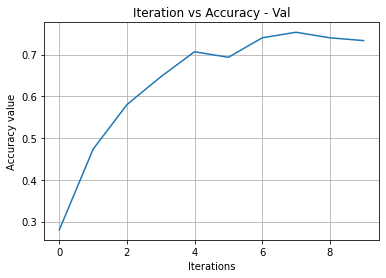

In [61]:
fig, ax = plt.subplots()
ax.plot(iterations, acc_list_val)

ax.set(xlabel='Iterations', ylabel='Accuracy value',
       title='Iteration vs Accuracy - Val')
ax.grid()

plt.show()

### Generating Confusion Matrix

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [63]:
len(y_pred)

999

In [64]:
cf_matrix = confusion_matrix(y_true, y_pred)

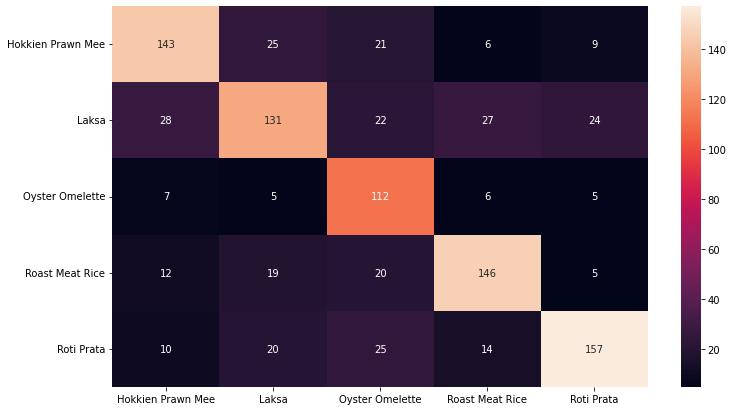

In [65]:
# constant for classes
# classes = ()

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm,fmt='', annot=True)
plt.savefig('effnetb1_lr0.001_output.png')

### Prediction Examples

In [66]:
predictions = pd.DataFrame({'Actual':y_true,'Predicted':y_pred})

In [67]:
predictions.head()

,Actual,Predicted
0,0,0
1,4,4
2,3,3
3,0,0
4,2,0
